<a href="https://colab.research.google.com/github/NgaAdrain/TEAM_Enter_Text_Here/blob/master/20200901_LAST_MODEL_Sim2Real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**<h1>SIM2REAL MODEL WITH CNN**</h1>

##**<h2>Module Import**</h2>


In [1]:
# Import the TensorFlow
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

https://tykimos.github.io/2017/06/10/Model_Save_Load/
<br>
모델 저장 및 가중치 저장 & 불러와서 사용하기

##**<h2>File Read**</h2>

###<h2>학습용 데이터 읽기 train_input.csv의 형식으로 저장한다</h2>

In [2]:
train_file = pd.read_csv('/content/train_input.csv',encoding='utf-8')
#train_file = pd.read_csv('/content/train_input4Sim2Sim.csv',encoding='utf-8')
train_file_label = train_file.pop('Label')
train_file.drop(['Timestamp','Winker(left)','Winker(right)','Timecheck'],axis = 'columns',inplace = True)

###<h2>시뮬레이션 테스트 데이터는 test_input.csv의 형식으로 저장한다.</h2>

In [3]:
test_file = pd.read_csv('/content/test_data.csv',encoding='utf-8')
#test_file = pd.read_csv('/content/test_data_1.csv',encoding='utf-8')
test_file_time = test_file.pop('Timestamp')
test_file_label = test_file.pop('Label')
test_file.drop(['Winker(left)','Winker(right)','Timecheck'],axis = 'columns',inplace = True)

###<h2>실제 데이터는 real_data.csv의 형식으로 저장한다.</h2>

In [4]:
real_file = pd.read_csv('/content/real_data.csv',encoding='utf-8')
#real_file = pd.read_csv('/content/real_data_1.csv',encoding='utf-8')
real_file_label = real_file.pop('Label')

##**<h2>DataFrame 2 Numpy Array**</h2>


###<h3>학습용 데이터 변환</h3>

In [5]:
train_array = np.delete(train_file.values,-1,0).astype(np.float)
train_label = np.delete(train_file_label.values,-1,0).astype(np.int)

###<h3>테스트 데이터 변환</h3>


In [6]:
test_array = np.delete(test_file.values,-1,0).astype(np.float)
test_label = np.delete(test_file_label.values,-1,0).astype(np.int)
test_time = np.delete(test_file_time.values,-1,0)

###<h3>실제 데이터 변환</h3>

In [7]:
real_array = np.delete(real_file.values,-1,0).astype(np.float)
real_label = np.delete(real_file_label.values,-1,0).astype(np.int)

###<h3>30Hz->10Hz로 데이터 갯수 맞추기</h3>

형진이가 만든 10hz변환기를 통과한 학습용 파일에는 필요가 없다!

=> 30Hz로 부터 10Hz의 데이터 3개를 뽑아낸다!

####<h3>학습용 데이터</h3>

In [8]:
train_10hz_array = []
train_10hz_label = []
count = 0
for temp in train_array:
  if(count%3 == 1):
    train_10hz_array.append(train_array[count,:])
    train_10hz_label.append(train_label[count])
  count = count + 1
count = 0
for temp in train_array:
  if(count%3 == 0):
    train_10hz_array.append(train_array[count,:])
    train_10hz_label.append(train_label[count])
  count = count + 1
count = 0
for temp in train_array:
  if(count%3 == 2):
    train_10hz_array.append(train_array[count,:])
    train_10hz_label.append(train_label[count])
  count = count + 1
train_array = np.array(train_10hz_array)
train_label = np.array(train_10hz_label)
print(len(train_array))
print(len(train_label))

312145
312145


####<h3>테스트 데이터</h3>

In [9]:
test_10hz_array = []
test_10hz_label = []
count = 0
for temp in test_array:
  if(count%3 == 1):
    test_10hz_array.append(test_array[count,:])
    test_10hz_label.append(test_label[count])
  count = count + 1
count = 0
for temp in test_array:
  if(count%3 == 0):
    test_10hz_array.append(test_array[count,:])
    test_10hz_label.append(test_label[count])
  count = count + 1
count = 0
for temp in test_array:
  if(count%3 == 2):
    test_10hz_array.append(test_array[count,:])
    test_10hz_label.append(test_label[count])
  count = count + 1
test_array = np.array(test_10hz_array)
test_label = np.array(test_10hz_label)
#print(test_array)
print(len(test_label))

18098


###<h3>데이터 길이</h3>

In [9]:
length_test = int(len(test_array)/25)
length_train = int(len(train_array)/25)
length_real = int(len(real_array)/25)

##**<h2>데이터 정규화**</h2>

###<h3>사용 상수</h3>

In [10]:
VELOCITY = 0
ACCEL_X = 1
ROT_Z = 2
STEERING = 3 
ACCEL = 4
BRAKE = 5
VELOCITY_MAX = 120
ACCEL_X_MAX =  2.0
ACCEL_X_MIN = -2.0
ROT_Z_MAX = 45
ROT_Z_MIN = -45
STEERING_MAX = 270
STEERING_MIN = -270
ACCEL_MAX = 80
BRAKE_MAX = 50

###<h3>범위 지정</h3>

In [11]:
print("Process 1-1 Velocity[",end="")
for i in range(len(train_array)):
  train_array[i][VELOCITY] = round(train_array[i][VELOCITY],0)
  if(i%length_train==0):
    print("#",end="")
  if(train_array[i][VELOCITY]>=VELOCITY_MAX):    #MAX
    train_array[i][VELOCITY] = VELOCITY_MAX
  else:
    continue
print("]\nProcess 1-2 Accel_X [",end="")
for i in range(len(train_array)):
  if(i%length_train==0):
    print("#",end="")  
  if(train_array[i][ACCEL_X]>=ACCEL_X_MAX):     #MAX
    train_array[i][ACCEL_X] = ACCEL_X_MAX
  elif(train_array[i][ACCEL_X]<=ACCEL_X_MIN):
    train_array[i][ACCEL_X] = ACCEL_X_MIN
  else:
    continue
print("]\nProcess 1-3 ROTATE_Z[",end="")
for i in range(len(train_array)):
  if(i%length_train==0):
    print("#",end="")
  if(train_array[i][ROT_Z]>=ROT_Z_MAX):       #MAX
    train_array[i][ROT_Z] = ROT_Z_MAX
  elif(train_array[i][ROT_Z]<=ROT_Z_MIN):     #MIN
    train_array[i][ROT_Z] = ROT_Z_MIN
  else:
    continue
print("]\nProcess 1-4 Steering[",end="")
for i in range(len(train_array)):
  if(i%length_train==0):
    print("#",end="")  
  if(train_array[i][STEERING]>=STEERING_MAX):    #MAX
    train_array[i][STEERING] = STEERING_MAX
  elif(train_array[i][STEERING]<= STEERING_MIN): #MIN
    train_array[i][STEERING] = STEERING_MIN
  else:
    continue
print("]\nProcess 1-5 Accelpad[",end="")
for i in range(len(train_array)):
  if(i%length_train==0):
    print("#",end="")  
  if(train_array[i][ACCEL]>=ACCEL_MAX):        #MAX
    train_array[i][ACCEL] = ACCEL_MAX
  else:
    continue
print("]\nProcess 1-6 Brakepad[",end="")
for i in range(len(train_array)):
  if(i%length_train==0):
    print("#",end="")
  if(train_array[i][BRAKE]>=BRAKE_MAX):        #MAX
    train_array[i][BRAKE] = BRAKE_MAX
  else:
    continue
print("]\nProcess 1 Clear")

Process 1-1 Velocity[##########################]
Process 1-2 Accel_X [##########################]
Process 1-3 ROTATE_Z[##########################]
Process 1-4 Steering[##########################]
Process 1-5 Accelpad[##########################]
Process 1-6 Brakepad[##########################]
Process 1 Clear


In [12]:
print("Process 2-1 Velocity[",end="")
for i in range(len(test_array)):
  test_array[i][VELOCITY] = round(test_array[i][VELOCITY],0)
  if(i%length_test==0):
    print("#",end="")
  if(test_array[i][VELOCITY]>=VELOCITY_MAX):    #MAX
    test_array[i][VELOCITY] = VELOCITY_MAX
  else:
    continue
print("]\nProcess 2-2 Accel_X [",end="")
for i in range(len(test_array)):
  if(i%length_test==0):
    print("#",end="")  
  if(test_array[i][ACCEL_X]>=ACCEL_X_MAX):     #MAX
    test_array[i][ACCEL_X] = ACCEL_X_MAX
  elif(test_array[i][ACCEL_X]<=ACCEL_X_MIN):
    test_array[i][ACCEL_X] = ACCEL_X_MIN
  else:
    continue
print("]\nProcess 2-3 ROTATE_Z[",end="")
for i in range(len(test_array)):
  if(i%length_test==0):
    print("#",end="")
  if(test_array[i][ROT_Z]>=ROT_Z_MAX):       #MAX
    test_array[i][ROT_Z] = ROT_Z_MAX
  elif(test_array[i][ROT_Z]<=ROT_Z_MIN):     #MIN
    test_array[i][ROT_Z] = ROT_Z_MIN
  else:
    continue
print("]\nProcess 2-4 Steering[",end="")
for i in range(len(test_array)):
  if(i%length_test==0):
    print("#",end="")  
  if(test_array[i][STEERING]>=STEERING_MAX):    #MAX
    test_array[i][STEERING] = STEERING_MAX
  elif(test_array[i][STEERING]<= STEERING_MIN): #MIN
    test_array[i][STEERING] = STEERING_MIN
  else:
    continue
print("]\nProcess 2-5 Accelpad[",end="")
for i in range(len(test_array)):
  if(i%length_test==0):
    print("#",end="")  
  if(test_array[i][ACCEL]>=ACCEL_MAX):        #MAX
    test_array[i][ACCEL] = ACCEL_MAX
  else:
    continue
print("]\nProcess 2-6 Brakepad[",end="")
for i in range(len(test_array)):
  if(i%length_test==0):
    print("#",end="")
  if(test_array[i][BRAKE]>=BRAKE_MAX):        #MAX
    test_array[i][BRAKE] = BRAKE_MAX
  else:
    continue
print("]\nProcess 2 Clear")

Process 2-1 Velocity[##########################]
Process 2-2 Accel_X [##########################]
Process 2-3 ROTATE_Z[##########################]
Process 2-4 Steering[##########################]
Process 2-5 Accelpad[##########################]
Process 2-6 Brakepad[##########################]
Process 2 Clear


In [13]:
print("Process 3-1 Velocity[",end="")
for i in range(len(real_array)):
  real_array[i][VELOCITY] = round(real_array[i][VELOCITY],0)
  if(i%length_real==0):
    print("#",end="")
  if(real_array[i][VELOCITY]>=VELOCITY_MAX):    #MAX
    real_array[i][VELOCITY] = VELOCITY_MAX
  else:
    continue
print("]\nProcess 3-2 Accel_X [",end="")
for i in range(len(real_array)):
  if(i%length_real==0):
    print("#",end="")  
  if(real_array[i][ACCEL_X]>=ACCEL_X_MAX):     #MAX
    real_array[i][ACCEL_X] = ACCEL_X_MAX
  elif(real_array[i][ACCEL_X]<=ACCEL_X_MIN):
    real_array[i][ACCEL_X] = ACCEL_X_MIN
  else:
    continue
print("]\nProcess 3-3 ROTATE_Z[",end="")
for i in range(len(real_array)):
  if(i%length_real==0):
    print("#",end="")
  if(real_array[i][ROT_Z]>=ROT_Z_MAX):       #MAX
    real_array[i][ROT_Z] = ROT_Z_MAX
  elif(real_array[i][ROT_Z]<=ROT_Z_MIN):     #MIN
    real_array[i][ROT_Z] = ROT_Z_MIN
  else:
    continue
print("]\nProcess 3-4 Steering[",end="")
for i in range(len(real_array)):
  if(i%length_real==0):
    print("#",end="")  
  if(real_array[i][STEERING]>=STEERING_MAX):    #MAX
    real_array[i][STEERING] = STEERING_MAX
  elif(real_array[i][STEERING]<= STEERING_MIN): #MIN
    real_array[i][STEERING] = STEERING_MIN
  else:
    continue
print("]\nProcess 3-5 Accelpad[",end="")
for i in range(len(real_array)):
  if(i%length_real==0):
    print("#",end="")  
  if(real_array[i][ACCEL]>=ACCEL_MAX):        #MAX
    real_array[i][ACCEL] = ACCEL_MAX
  else:
    continue
print("]\nProcess 3-6 Brakepad[",end="")
for i in range(len(real_array)):
  if(i%length_real==0):
    print("#",end="")
  if(real_array[i][BRAKE]>=BRAKE_MAX):        #MAX
    real_array[i][BRAKE] = BRAKE_MAX
  else:
    continue
print("]\nProcess 3 Clear")

Process 3-1 Velocity[##########################]
Process 3-2 Accel_X [##########################]
Process 3-3 ROTATE_Z[##########################]
Process 3-4 Steering[##########################]
Process 3-5 Accelpad[##########################]
Process 3-6 Brakepad[##########################]
Process 3 Clear


In [14]:
reg = [1,4,2,1,1,1]
reg = np.array(reg)
print(train_array.max(axis=0))
print(test_array.max(axis=0))
train_array = train_array/reg
test_array = test_array/reg
print(train_array.max(axis=0))
print(test_array.max(axis=0))

[115.         1.999753  44.9984   270.        80.        50.      ]
[ 91.       2.      20.1396 169.      52.      50.    ]
[115.           0.49993825  22.4992     270.          80.
  50.        ]
[ 91.       0.5     10.0698 169.      52.      50.    ]


###<h3> -1 ~ 1 정규화 작업 </h3>

In [ ]:
norm_train = train_array.max(axis=0)
norm_test = test_array.max(axis=0)
norm_real = real_array.max(axis=0)
print(norm_train)
print(train_array.min(axis=0))
print(norm_test)
print(test_array.min(axis=0))
norm_train[1] = 1
norm_test[1] = 1
norm_real[1] = 1
train = train_array / norm_train
test = test_array / norm_test
real = real_array / norm_real

[115.           0.49993825  22.4992     365.         100.
 100.        ]
[   0.           -0.49988425  -22.49885    -239.            0.
    0.        ]
[120.           0.49579275  12.8085     169.         100.
  64.        ]
[   0.          -0.4976665  -21.76345   -172.           0.
    0.       ]


In [ ]:
#30hz
train_dataset_data = []
train_dataset_label = []
for i in range(WINDOW_SIZE, train.shape[0] + 1, 1):
  train_dataset_data.append(train[i-WINDOW_SIZE:i])
  train_dataset_label.append(train_label[i-1])
#for i in range(WINDOW_SIZE, train.shape[0] + 1, 1):
#  train_dataset_data.append(train[i-WINDOW_SIZE:i])
#  train_dataset_label.append(train_label[i-1])
tr_data = np.array(train_dataset_data)
tr_label = np.array(train_dataset_label) 

print(tr_data.shape)
print(tr_label.shape)

In [ ]:
#30hz
test_dataset_data = []
test_dataset_label = []
for i in range(WINDOW_SIZE, test.shape[0] + 1, 1):
  test_dataset_data.append(test[i-WINDOW_SIZE:i])
  test_dataset_label.append(test_label[i-1])
#for i in range(WINDOW_SIZE, test.shape[0] + 1, 1):
#  test_dataset_data.append(test[i-WINDOW_SIZE:i])
#  test_dataset_label.append(test_label[i-1])
te_data = np.array(test_dataset_data)
te_label = np.array(test_dataset_label) 
print(te_data.shape)

(18051, 48, 6)


In [16]:
real_dataset_data = []
real_dataset_label = []
for i in range(WINDOW_SIZE, real.shape[0] + 1, 1):
  real_dataset_data.append(real[i-WINDOW_SIZE:i])
  real_dataset_label.append(real_label[i-1])
#for i in range(WINDOW_SIZE, real.shape[0] + 1, 1):
#  real_dataset_data.append(real[i-WINDOW_SIZE:i])
#  real_dataset_label.append(real_label[i-1])
re_data = np.array(real_dataset_data)
re_label = np.array(real_dataset_label) 
print(re_data.shape)

NameError: ignored

##**<h2>데이터셋 만들기**</h2>

###<h1>사용 상수</h1>

In [15]:
#초당 32개의 데이터가 나옴.(30~32Hz) => 10Hz 획일화함.
WINDOW_SIZE = 48 #4.8초 분량

###<h2>Convolution Neural Network Dataset</h2>

####<h3>학습용 데이터셋</h3>

In [16]:
#30hz
train_dataset_data = []
train_dataset_label = []
for i in range(WINDOW_SIZE, train_array.shape[0] + 1, 1):
  train_dataset_data.append(train_array[i-WINDOW_SIZE:i])
  train_dataset_label.append(train_label[i-1])
tr_data = np.array(train_dataset_data)
tr_label = np.array(train_dataset_label) 

print(tr_data.shape)
print(tr_label.shape)

(312098, 48, 6)
(312098,)


####<h3>테스트 데이터셋</h3>

In [17]:
#30hz
test_dataset_data = []
test_dataset_label = []
for i in range(WINDOW_SIZE, test_array.shape[0] + 1, 1):
  test_dataset_data.append(test_array[i-WINDOW_SIZE:i])
  test_dataset_label.append(test_label[i-1])
#for i in range(WINDOW_SIZE, test.shape[0] + 1, 1):
#  test_dataset_data.append(test[i-WINDOW_SIZE:i])
#  test_dataset_label.append(test_label[i-1])
te_data = np.array(test_dataset_data)
te_label = np.array(test_dataset_label) 
print(te_data.shape)

(3415, 48, 6)


####<h3>실제 데이터셋</h3>

In [18]:
real_dataset_data = []
real_dataset_label = []
for i in range(WINDOW_SIZE, real_array.shape[0] + 1, 1):
  real_dataset_data.append(real_array[i-WINDOW_SIZE:i])
  real_dataset_label.append(real_label[i-1])
#for i in range(WINDOW_SIZE, real.shape[0] + 1, 1):
#  real_dataset_data.append(real[i-WINDOW_SIZE:i])
#  real_dataset_label.append(real_label[i-1])
re_data = np.array(real_dataset_data)
re_label = np.array(real_dataset_label) 
print(re_data.shape)

(23141, 48, 6)


####각 데이터 셋 array에 차원을 추가

In [19]:
##여기 구현
##TO DO: data의 구조를 (None,총 column 수, WINDOW크기, 라벨수)로 바꿔야함. 4차원으로 변경
tr_c_data = tr_data.reshape(-1,6,WINDOW_SIZE,1)
te_c_data = te_data.reshape(-1,6,WINDOW_SIZE,1)
re_c_data = re_data.reshape(-1,6,WINDOW_SIZE,1)
print(tr_c_data.shape)

(312098, 6, 48, 1)


##**<h2>상태 분석 모델링**</h2>

###<h2>Convolution Neural Network Model</h2>

Convolution neural Network에서 합성곱 신경망의 필터를 통과할 때(Conv2D-> 2차원 필터) 데이터는 차원이 낮아지게 된다.<br>
NxN의 vector가 FxF의 필터를 통과하게되면 (N-F+1)x(N-F+1)로 줄어들게 된다.<br>
즉 지금 여기의 예시에서는 120(윈도우 크기) x 5를 3x3이 통과하게 되면 118 x 3으로 줄어든다.<br>
이를 MaxPool2D의 2x2필터를 통과하게 되면 117x2로 줄어들게 되며 다시한번 Conv2D의 2x2 필터를 통과하게 되면 116x1로 줄어들어서 더이상 Convolution필터를 통과할 수 없게 된다.<br>
이 때문에 많은 필터 layer를 추가하지 못하므로 이를 해결하기위해 padding 기술을 사용한다.<br>
padding기술은 각 edge의 값을 복사하여 각 방향으로 한 칸 늘려서 크기를 유지하는 기술이다.<br>
Conv2D에서는 padding을 사용하지 않는 valid, padding을 사용하는 same의 두가지를 지원한다. 이를 사용하면 많은 layer를 넣을 수 있다. 이를 이용하여 해결하였다.

MAX_POOLING vs CONV2D STRIDE옵션

FLATTEN vs GAP(Global Average Pooling)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 48, 16)         160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 24, 32)         4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 24, 32)         9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 12, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 12, 64)         36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         1

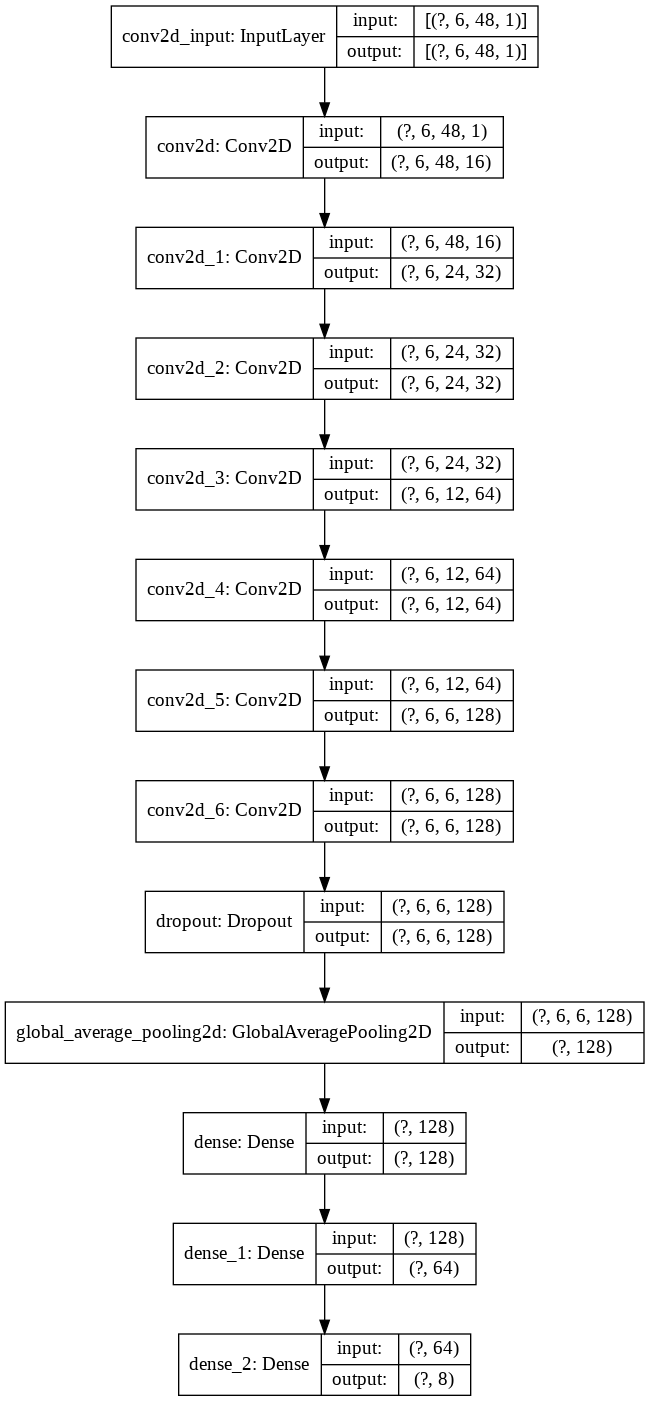

In [20]:
cnn_model_main = keras.Sequential([
    keras.layers.Conv2D(16,3,padding='same',activation='relu',input_shape = (6,WINDOW_SIZE,1)),
    keras.layers.Conv2D(32,3,strides=(1,2),padding='same',activation='relu'),
    keras.layers.Conv2D(32,3,padding='same',activation='relu'),
    keras.layers.Conv2D(64,3,strides=(1,2),padding='same',activation='relu'),
    keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    keras.layers.Conv2D(128,3,strides=(1,2),padding='same',activation='relu'),
    keras.layers.Conv2D(128,3,activation='relu',padding='same'),
    keras.layers.Dropout(0.1),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(8, activation='softmax')  #stop 빼는 경우
])
cnn_model_main.summary()
cnn_model_main.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
tf.keras.utils.plot_model(cnn_model_main, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 6, 48, 16)         160       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 24, 32)         4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 24, 32)         9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 12, 64)         18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 12, 64)         36928     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 128)         73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 6, 128)        

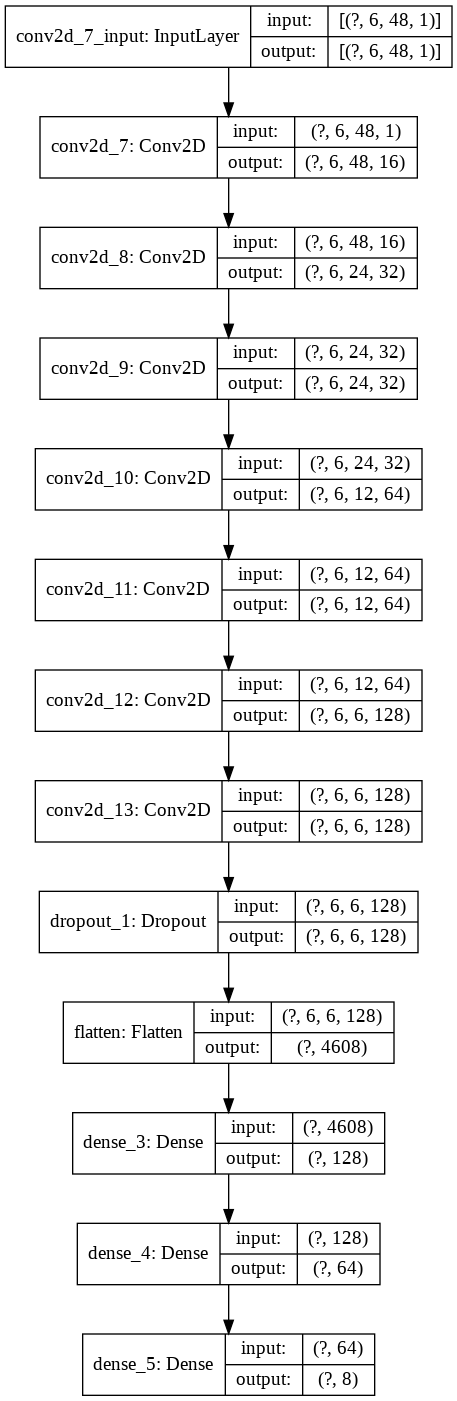

In [21]:
cnn_model_sub = keras.Sequential([
    keras.layers.Conv2D(16,3,padding='same',activation='relu',input_shape = (6,WINDOW_SIZE,1)), 
    keras.layers.Conv2D(32,3,strides=(1,2),padding='same',activation='relu'),
    keras.layers.Conv2D(32,3,padding='same',activation='relu'),
    keras.layers.Conv2D(64,3,strides=(1,2),padding='same',activation='relu'),
    keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    keras.layers.Conv2D(128,3,strides=(1,2),padding='same',activation='relu'),
    keras.layers.Conv2D(128,3,activation='relu',padding='same'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(8, activation='softmax')  #stop 빼는 경우
])
cnn_model_sub.summary()
cnn_model_sub.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
tf.keras.utils.plot_model(cnn_model_sub, show_shapes=True)

###CNN MODEL 학습

In [22]:
model_checkpoint_callback_1 = keras.callbacks.ModelCheckpoint(
    filepath= '/content',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
model_checkpoint_callback_2 = keras.callbacks.ModelCheckpoint(
    filepath= '/content/sample_data',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [23]:
cnn_history_1 = cnn_model_main.fit(tr_c_data , tr_label , epochs=10, batch_size=64, callbacks = [model_checkpoint_callback_1], validation_data=(te_c_data, te_label))

Epoch 1/10
4877/4877 [==============================] - 22s 5ms/step - loss: 0.3279 - accuracy: 0.8822 - val_loss: 0.7468 - val_accuracy: 0.8275
Epoch 2/10
4877/4877 [==============================] - 22s 4ms/step - loss: 0.1425 - accuracy: 0.9477 - val_loss: 0.8321 - val_accuracy: 0.8114
Epoch 3/10
4877/4877 [==============================] - 22s 4ms/step - loss: 0.0964 - accuracy: 0.9645 - val_loss: 0.9710 - val_accuracy: 0.8158
Epoch 4/10
4877/4877 [==============================] - 22s 4ms/step - loss: 0.0766 - accuracy: 0.9726 - val_loss: 0.8773 - val_accuracy: 0.8272
Epoch 5/10
4877/4877 [==============================] - 21s 4ms/step - loss: 0.0647 - accuracy: 0.9771 - val_loss: 1.2728 - val_accuracy: 0.7962
Epoch 6/10
4877/4877 [==============================] - 21s 4ms/step - loss: 0.0566 - accuracy: 0.9799 - val_loss: 1.1005 - val_accuracy: 0.8100
Epoch 7/10
4877/4877 [==============================] - 21s 4ms/step - loss: 0.0514 - accuracy: 0.9819 - val_loss: 1.3638 - val_ac

In [24]:
cnn_history_2 = cnn_model_sub.fit(tr_c_data , tr_label , epochs=10 , batch_size=64, callbacks = [model_checkpoint_callback_2], validation_data=(re_c_data, re_label))

Epoch 1/10
4877/4877 [==============================] - 22s 5ms/step - loss: 0.2860 - accuracy: 0.8974 - val_loss: 0.5225 - val_accuracy: 0.8684
Epoch 2/10
4877/4877 [==============================] - 22s 4ms/step - loss: 0.1325 - accuracy: 0.9516 - val_loss: 0.7234 - val_accuracy: 0.8531
Epoch 3/10
4877/4877 [==============================] - 22s 5ms/step - loss: 0.1009 - accuracy: 0.9639 - val_loss: 0.9213 - val_accuracy: 0.8705
Epoch 4/10
4877/4877 [==============================] - 22s 5ms/step - loss: 0.0848 - accuracy: 0.9699 - val_loss: 0.9071 - val_accuracy: 0.8429
Epoch 5/10
4877/4877 [==============================] - 22s 4ms/step - loss: 0.0790 - accuracy: 0.9726 - val_loss: 1.2416 - val_accuracy: 0.8539
Epoch 6/10
4877/4877 [==============================] - 22s 4ms/step - loss: 0.0771 - accuracy: 0.9738 - val_loss: 1.0524 - val_accuracy: 0.8519
Epoch 7/10
4877/4877 [==============================] - 22s 4ms/step - loss: 0.0693 - accuracy: 0.9765 - val_loss: 0.9100 - val_ac

###학습 확인


In [25]:
import matplotlib.pyplot as plt

In [ ]:
def plot_metrics(history):
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  metrics = ['loss', 'accuracy']
  for n, metrics in enumerate(metrics):
    name = metrics.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metrics],color=colors[0],label='Train')
    plt.plot(history.epoch, history.history['val_'+ metrics],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metrics == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metrics == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()


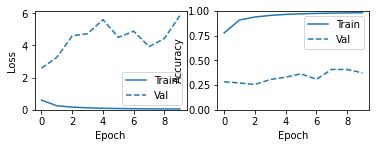

In [ ]:
plot_metrics(cnn_history_1)

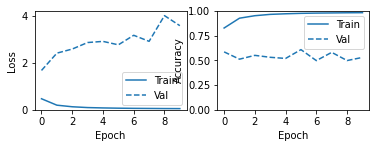

In [ ]:
plot_metrics(cnn_history_2)

##<h2>**모델 예측**</h2>

###CNN 예측

In [26]:
cnn_test_predictions_1 = cnn_model_main.predict(te_c_data)
cnn_test_predictions_2 = cnn_model_sub.predict(te_c_data)
cnn_real_predictions_1 = cnn_model_main.predict(re_c_data)
cnn_real_predictions_2 = cnn_model_sub.predict(re_c_data)

In [27]:
from keras.models import load_model
cnn_model_main.save('Sim2Real_Model_CNN_GAP_Final.h5')
cnn_model_sub.save('Sim2Real_Model_CNN_FLATTEN_Final.h5')

In [28]:
cnn_model_main.load_weights('/content')
cnn_model_sub.load_weights('/content/sample_data')
cnn_test_predictions_3 = cnn_model_main.predict(te_c_data)
cnn_test_predictions_4 = cnn_model_sub.predict(te_c_data)
cnn_real_predictions_3 = cnn_model_main.predict(re_c_data)
cnn_real_predictions_4 = cnn_model_sub.predict(re_c_data)

In [29]:
cnn_model_main.save('Sim2Real_Model_CNN_GAP_Best.h5')
cnn_model_sub.save('Sim2Real_Model_CNN_FLATTEN_Best.h5')

####Model Merge

In [30]:
def model_prediction_merge(prediction_1,prediction_2):
  count = 0
  cnn_prediction = []
  for main_pred in prediction_1:
    if 0 < np.argmax(prediction_2[count]) < 5:
      cnn_prediction.append(np.argmax(prediction_2[count]))
    else:
      cnn_prediction.append(np.argmax(main_pred))
    count = count + 1
  cnn_prediction = np.array(cnn_prediction)
  return cnn_prediction

In [31]:
print(type(cnn_test_predictions_1))
cnn_test_predictions = model_prediction_merge(cnn_test_predictions_1,cnn_test_predictions_2)
"""
count = 0
cnn_test_predictions = []
for main_pred in cnn_test_predictions_1:
  if 0 < np.argmax(cnn_test_predictions_2[count]) < 5:
    cnn_test_predictions.append(np.argmax(cnn_test_predictions_2[count]))
  else:
    cnn_test_predictions.append(np.argmax(main_pred))
  count = count + 1
cnn_test_predictions = np.array(cnn_test_predictions)
"""

<class 'numpy.ndarray'>


'\ncount = 0\ncnn_test_predictions = []\nfor main_pred in cnn_test_predictions_1:\n  if 0 < np.argmax(cnn_test_predictions_2[count]) < 5:\n    cnn_test_predictions.append(np.argmax(cnn_test_predictions_2[count]))\n  else:\n    cnn_test_predictions.append(np.argmax(main_pred))\n  count = count + 1\ncnn_test_predictions = np.array(cnn_test_predictions)\n'

In [32]:
print(type(cnn_real_predictions_1))
cnn_real_predictions = model_prediction_merge(cnn_real_predictions_1,cnn_real_predictions_2)
"""'
count = 0
cnn_real_predictions = []
for main_pred in cnn_real_predictions_1:
  if 0 < np.argmax(cnn_real_predictions_2[count]) < 5:
    cnn_real_predictions.append(np.argmax(cnn_real_predictions_2[count]))
  else:
    cnn_real_predictions.append(np.argmax(main_pred))
  count = count + 1
cnn_real_predictions = np.array(cnn_real_predictions)
"""

<class 'numpy.ndarray'>


"'\ncount = 0\ncnn_real_predictions = []\nfor main_pred in cnn_real_predictions_1:\n  if 0 < np.argmax(cnn_real_predictions_2[count]) < 5:\n    cnn_real_predictions.append(np.argmax(cnn_real_predictions_2[count]))\n  else:\n    cnn_real_predictions.append(np.argmax(main_pred))\n  count = count + 1\ncnn_real_predictions = np.array(cnn_real_predictions)\n"

In [33]:
print(type(cnn_test_predictions_3))
cnn_test_predictions_5 = model_prediction_merge(cnn_test_predictions_3,cnn_test_predictions_4)
"""
count = 0
cnn_test_predictions_5 = []
for main_pred in cnn_test_predictions_3:
  if 0 < np.argmax(cnn_test_predictions_4[count]) < 5:
    cnn_test_predictions_5.append(np.argmax(cnn_test_predictions_4[count]))
  else:
    cnn_test_predictions_5.append(np.argmax(main_pred))
  count = count + 1
cnn_test_predictions_5 = np.array(cnn_test_predictions_5)
"""

<class 'numpy.ndarray'>


'\ncount = 0\ncnn_test_predictions_5 = []\nfor main_pred in cnn_test_predictions_3:\n  if 0 < np.argmax(cnn_test_predictions_4[count]) < 5:\n    cnn_test_predictions_5.append(np.argmax(cnn_test_predictions_4[count]))\n  else:\n    cnn_test_predictions_5.append(np.argmax(main_pred))\n  count = count + 1\ncnn_test_predictions_5 = np.array(cnn_test_predictions_5)\n'

In [34]:
print(type(cnn_real_predictions_3))
cnn_real_predictions_5 = model_prediction_merge(cnn_real_predictions_3,cnn_real_predictions_4)
"""
count = 0
cnn_real_predictions_5 = []
for main_pred in cnn_real_predictions_3:
  if 0 < np.argmax(cnn_real_predictions_4[count]) < 5:
    cnn_real_predictions_5.append(np.argmax(cnn_real_predictions_4[count]))
  else:
    cnn_real_predictions_5.append(np.argmax(main_pred))
  count = count + 1
cnn_real_predictions_5 = np.array(cnn_real_predictions_5)
"""

<class 'numpy.ndarray'>


'\ncount = 0\ncnn_real_predictions_5 = []\nfor main_pred in cnn_real_predictions_3:\n  if 0 < np.argmax(cnn_real_predictions_4[count]) < 5:\n    cnn_real_predictions_5.append(np.argmax(cnn_real_predictions_4[count]))\n  else:\n    cnn_real_predictions_5.append(np.argmax(main_pred))\n  count = count + 1\ncnn_real_predictions_5 = np.array(cnn_real_predictions_5)\n'

####cnn 테스트 데이터

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def show_conf_matrix(label, predictions):
  matrix = confusion_matrix(label, predictions)#_2.argmax(axis=1))
  print(matrix)
  print(np.bincount(label)[:, np.newaxis])
  conf_mat = (matrix / np.bincount(label)[:, np.newaxis] * 100).astype(np.int)
  print(conf_mat)
  plt.figure(figsize=(8,6))
  sns.heatmap(conf_mat,annot=True,fmt="d",cmap='Greens')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[[1610   30   41   26   38  203   89    6]
 [  12  233    0   16    0    5   19    0]
 [ 101    0   86    0   21    2    4    2]
 [   6   12    0  108    5   15    0    0]
 [  38    2   11    4  356    4    5    0]
 [   6    0    0    1    0   37    0    0]
 [  19    0    3    0    0    3   60    0]
 [   0    0    0    0    0    0    0  176]]
[[2043]
 [ 285]
 [ 216]
 [ 146]
 [ 420]
 [  44]
 [  85]
 [ 176]]
[[ 78   1   2   1   1   9   4   0]
 [  4  81   0   5   0   1   6   0]
 [ 46   0  39   0   9   0   1   0]
 [  4   8   0  73   3  10   0   0]
 [  9   0   2   0  84   0   1   0]
 [ 13   0   0   2   0  84   0   0]
 [ 22   0   3   0   0   3  70   0]
 [  0   0   0   0   0   0   0 100]]


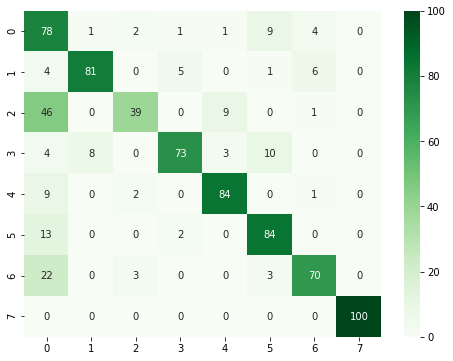

In [38]:
show_conf_matrix(te_label,cnn_test_predictions)

[[1630   21   36   21   29  211   89    6]
 [  19  233    0    9    0    5   19    0]
 [ 105    0   85    2   16    2    4    2]
 [   6    8    0  116    0   16    0    0]
 [  42    2    5    1  357    7    6    0]
 [   6    0    0    0    0   38    0    0]
 [  19    0    3    0    0    3   60    0]
 [   0    0    0    0    0    0    0  176]]
[[2043]
 [ 285]
 [ 216]
 [ 146]
 [ 420]
 [  44]
 [  85]
 [ 176]]
[[ 79   1   1   1   1  10   4   0]
 [  6  81   0   3   0   1   6   0]
 [ 48   0  39   0   7   0   1   0]
 [  4   5   0  79   0  10   0   0]
 [ 10   0   1   0  85   1   1   0]
 [ 13   0   0   0   0  86   0   0]
 [ 22   0   3   0   0   3  70   0]
 [  0   0   0   0   0   0   0 100]]


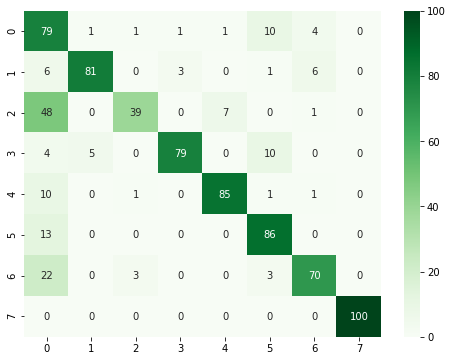

In [39]:
show_conf_matrix(te_label,cnn_test_predictions_1.argmax(axis=1))

[[1800   25    7    9   21   72  108    1]
 [  25  208    0   10    0   13   29    0]
 [ 128    0   35    0   17   17   19    0]
 [   9   12    0  106    5   14    0    0]
 [  40    0   11    3  330   15   21    0]
 [   6    0    0    1    0   37    0    0]
 [  25    0    0    0    0    0   60    0]
 [   3    0    0    0    0    0    0  173]]
[[2043]
 [ 285]
 [ 216]
 [ 146]
 [ 420]
 [  44]
 [  85]
 [ 176]]
[[88  1  0  0  1  3  5  0]
 [ 8 72  0  3  0  4 10  0]
 [59  0 16  0  7  7  8  0]
 [ 6  8  0 72  3  9  0  0]
 [ 9  0  2  0 78  3  5  0]
 [13  0  0  2  0 84  0  0]
 [29  0  0  0  0  0 70  0]
 [ 1  0  0  0  0  0  0 98]]


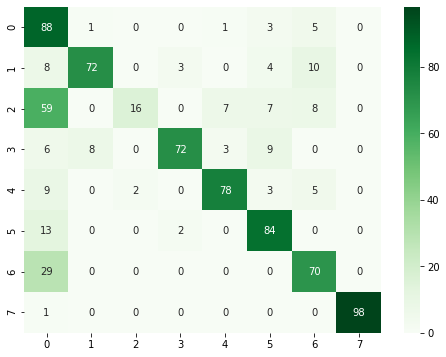

In [40]:
show_conf_matrix(te_label,cnn_test_predictions_2.argmax(axis=1))

####cnn Callback 테스트 데이터

[[1724   25    9   16   39   86  132   12]
 [  18  219    0   10    0   30    8    0]
 [  33    0  124    1   42    1   12    3]
 [   4   15    0  111    5   11    0    0]
 [  30    0   11    5  363    0   11    0]
 [   6    0    0    1    0   37    0    0]
 [  19    0    3    0    0    0   63    0]
 [   1    0    0    0    0    0    0  175]]
[[2043]
 [ 285]
 [ 216]
 [ 146]
 [ 420]
 [  44]
 [  85]
 [ 176]]
[[84  1  0  0  1  4  6  0]
 [ 6 76  0  3  0 10  2  0]
 [15  0 57  0 19  0  5  1]
 [ 2 10  0 76  3  7  0  0]
 [ 7  0  2  1 86  0  2  0]
 [13  0  0  2  0 84  0  0]
 [22  0  3  0  0  0 74  0]
 [ 0  0  0  0  0  0  0 99]]


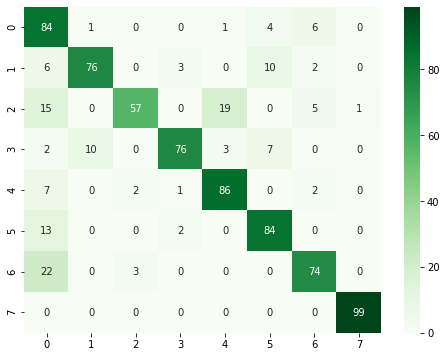

In [41]:
show_conf_matrix(te_label,cnn_test_predictions_5)

[[1735   19    4    7   36   96  134   12]
 [  25  219    0    3    0   30    8    0]
 [  33    0  124    1   41    1   13    3]
 [   4   11    0  110    5   16    0    0]
 [  33    0   11    2  362    0   12    0]
 [   6    0    0    0    0   38    0    0]
 [  19    0    3    0    0    0   63    0]
 [   1    0    0    0    0    0    0  175]]
[[2043]
 [ 285]
 [ 216]
 [ 146]
 [ 420]
 [  44]
 [  85]
 [ 176]]
[[84  0  0  0  1  4  6  0]
 [ 8 76  0  1  0 10  2  0]
 [15  0 57  0 18  0  6  1]
 [ 2  7  0 75  3 10  0  0]
 [ 7  0  2  0 86  0  2  0]
 [13  0  0  0  0 86  0  0]
 [22  0  3  0  0  0 74  0]
 [ 0  0  0  0  0  0  0 99]]


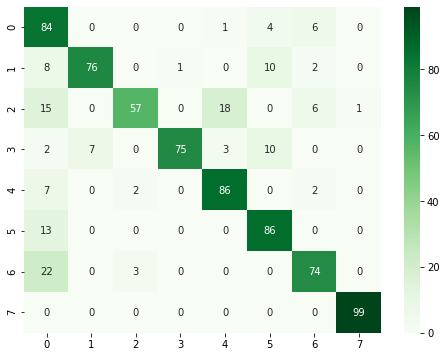

In [42]:
show_conf_matrix(te_label,cnn_test_predictions_3.argmax(axis=1))

[[1800   25    7    9   21   72  108    1]
 [  25  208    0   10    0   13   29    0]
 [ 128    0   35    0   17   17   19    0]
 [   9   12    0  106    5   14    0    0]
 [  40    0   11    3  330   15   21    0]
 [   6    0    0    1    0   37    0    0]
 [  25    0    0    0    0    0   60    0]
 [   3    0    0    0    0    0    0  173]]
[[2043]
 [ 285]
 [ 216]
 [ 146]
 [ 420]
 [  44]
 [  85]
 [ 176]]
[[88  1  0  0  1  3  5  0]
 [ 8 72  0  3  0  4 10  0]
 [59  0 16  0  7  7  8  0]
 [ 6  8  0 72  3  9  0  0]
 [ 9  0  2  0 78  3  5  0]
 [13  0  0  2  0 84  0  0]
 [29  0  0  0  0  0 70  0]
 [ 1  0  0  0  0  0  0 98]]


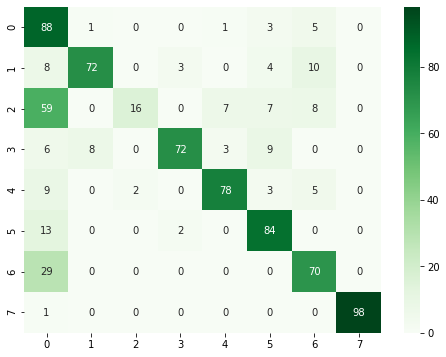

In [43]:
show_conf_matrix(te_label,cnn_test_predictions_4.argmax(axis=1))

####cnn 실제 데이터

[[9119   18   59   47   47  150   37  115]
 [ 525 1078    1  122    2  149    0    0]
 [ 408    0  535    0  243   31   10    4]
 [  89   16    0  675    2    0    0    0]
 [  35    0    1    0  855    0    0    0]
 [ 149   31    0   33    5  433    0    0]
 [ 113    0   27    1   42    1  287    0]
 [ 121    1    2    1    1    0    0 7520]]
[[9592]
 [1877]
 [1231]
 [ 782]
 [ 891]
 [ 651]
 [ 471]
 [7646]]
[[95  0  0  0  0  1  0  1]
 [27 57  0  6  0  7  0  0]
 [33  0 43  0 19  2  0  0]
 [11  2  0 86  0  0  0  0]
 [ 3  0  0  0 95  0  0  0]
 [22  4  0  5  0 66  0  0]
 [23  0  5  0  8  0 60  0]
 [ 1  0  0  0  0  0  0 98]]


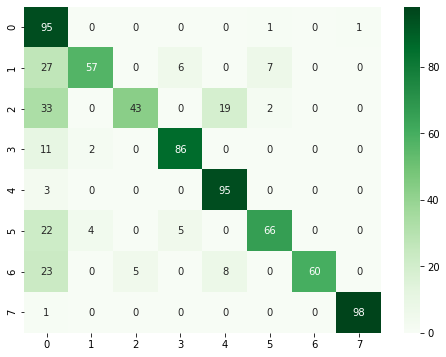

In [44]:
show_conf_matrix(re_label,cnn_real_predictions)

[[9142   15   53   32   40  153   37  120]
 [ 562 1019    0  111    1  184    0    0]
 [ 452    0  507    0  219   32   11   10]
 [  93   11    0  669    0    3    0    6]
 [  39    0    1    0  811    0    0   40]
 [ 155    8    0   22    0  466    0    0]
 [ 114    0   27    1   41    1  287    0]
 [ 122    1    0    1    1    0    0 7521]]
[[9592]
 [1877]
 [1231]
 [ 782]
 [ 891]
 [ 651]
 [ 471]
 [7646]]
[[95  0  0  0  0  1  0  1]
 [29 54  0  5  0  9  0  0]
 [36  0 41  0 17  2  0  0]
 [11  1  0 85  0  0  0  0]
 [ 4  0  0  0 91  0  0  4]
 [23  1  0  3  0 71  0  0]
 [24  0  5  0  8  0 60  0]
 [ 1  0  0  0  0  0  0 98]]


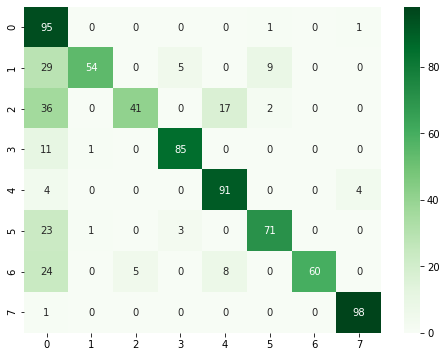

In [45]:
show_conf_matrix(re_label,cnn_real_predictions_1.argmax(axis=1))

[[9314    4   31   42   31   52   46   72]
 [ 798  799    1   74    1  203    1    0]
 [ 517    0  402    0  206   37   66    3]
 [ 103   14    0  654    2    9    0    0]
 [  44    0    0    0  844    3    0    0]
 [ 173   24    0   29    5  416    4    0]
 [  92    0    0    0    8    0  371    0]
 [ 134    0    2    0    1    0    0 7509]]
[[9592]
 [1877]
 [1231]
 [ 782]
 [ 891]
 [ 651]
 [ 471]
 [7646]]
[[97  0  0  0  0  0  0  0]
 [42 42  0  3  0 10  0  0]
 [41  0 32  0 16  3  5  0]
 [13  1  0 83  0  1  0  0]
 [ 4  0  0  0 94  0  0  0]
 [26  3  0  4  0 63  0  0]
 [19  0  0  0  1  0 78  0]
 [ 1  0  0  0  0  0  0 98]]


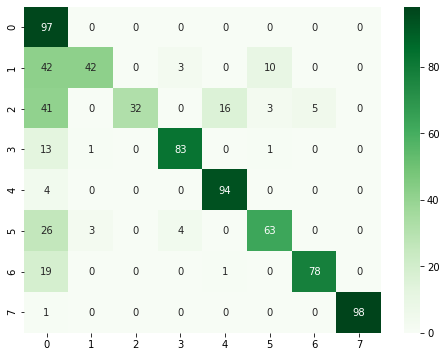

In [46]:
show_conf_matrix(re_label,cnn_real_predictions_2.argmax(axis=1))

####cnn Callback 실제 데이터

[[9193    4   40   45  137   31   13  129]
 [ 707  936    3   79    8  141    0    3]
 [ 442    0  440    0  267   22   60    0]
 [  99   19    0  661    2    1    0    0]
 [   3    0    0    0  888    0    0    0]
 [ 186   24    0   29    5  398    9    0]
 [  97    0    0    0   48    0  326    0]
 [ 119    0    2    1  654    0    0 6870]]
[[9592]
 [1877]
 [1231]
 [ 782]
 [ 891]
 [ 651]
 [ 471]
 [7646]]
[[95  0  0  0  1  0  0  1]
 [37 49  0  4  0  7  0  0]
 [35  0 35  0 21  1  4  0]
 [12  2  0 84  0  0  0  0]
 [ 0  0  0  0 99  0  0  0]
 [28  3  0  4  0 61  1  0]
 [20  0  0  0 10  0 69  0]
 [ 1  0  0  0  8  0  0 89]]


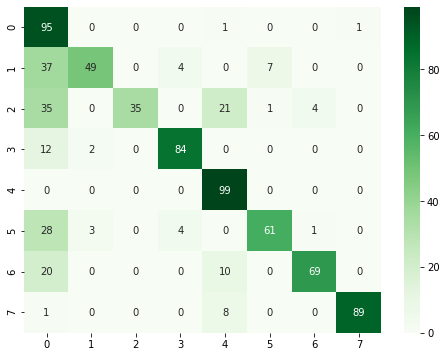

In [47]:
show_conf_matrix(re_label,cnn_real_predictions_5)

[[9213    0   34   30  137   36   13  129]
 [ 804  830    2   44    8  186    0    3]
 [ 490    0  373    0  280   22   66    0]
 [ 123   12    0  627    1   19    0    0]
 [   3    0    0    0  888    0    0    0]
 [ 193    0    0   11    0  438    9    0]
 [  97    0    0    0   47    0  327    0]
 [ 119    0    0    1  656    0    0 6870]]
[[9592]
 [1877]
 [1231]
 [ 782]
 [ 891]
 [ 651]
 [ 471]
 [7646]]
[[96  0  0  0  1  0  0  1]
 [42 44  0  2  0  9  0  0]
 [39  0 30  0 22  1  5  0]
 [15  1  0 80  0  2  0  0]
 [ 0  0  0  0 99  0  0  0]
 [29  0  0  1  0 67  1  0]
 [20  0  0  0  9  0 69  0]
 [ 1  0  0  0  8  0  0 89]]


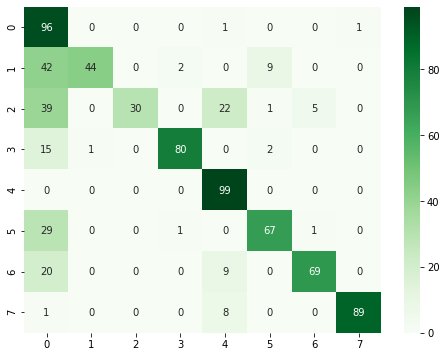

In [48]:
show_conf_matrix(re_label,cnn_real_predictions_3.argmax(axis=1))

[[9314    4   31   42   31   52   46   72]
 [ 798  799    1   74    1  203    1    0]
 [ 517    0  402    0  206   37   66    3]
 [ 103   14    0  654    2    9    0    0]
 [  44    0    0    0  844    3    0    0]
 [ 173   24    0   29    5  416    4    0]
 [  92    0    0    0    8    0  371    0]
 [ 134    0    2    0    1    0    0 7509]]
[[9592]
 [1877]
 [1231]
 [ 782]
 [ 891]
 [ 651]
 [ 471]
 [7646]]
[[97  0  0  0  0  0  0  0]
 [42 42  0  3  0 10  0  0]
 [41  0 32  0 16  3  5  0]
 [13  1  0 83  0  1  0  0]
 [ 4  0  0  0 94  0  0  0]
 [26  3  0  4  0 63  0  0]
 [19  0  0  0  1  0 78  0]
 [ 1  0  0  0  0  0  0 98]]


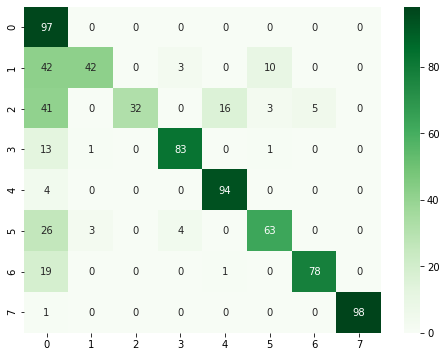

In [49]:
show_conf_matrix(re_label,cnn_real_predictions_4.argmax(axis=1))

In [50]:
print(len(test_file_label))
print(len(test_label))
print(len(cnn_test_predictions))

3463
3462
3415


In [51]:
print(len(real_file_label))
print(len(real_label))
print(len(cnn_real_predictions))

23189
23188
23141
